In [51]:
%matplotlib inline

In [52]:
import pandas as pd
import numpy as np
import requests
import json
import pprint as pprint
import hvplot.pandas
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [53]:
df = pd.read_csv("Resources/meteorite-landings-clean.csv")
df.shape


(31705, 8)

In [54]:
df.head()

,Unnamed: 0,name,mass,fall,year,reclat,reclong,GeoLocation
0,0,Aachen,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,1,Aarhus,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,2,Abee,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,3,Acapulco,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,4,Achiras,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


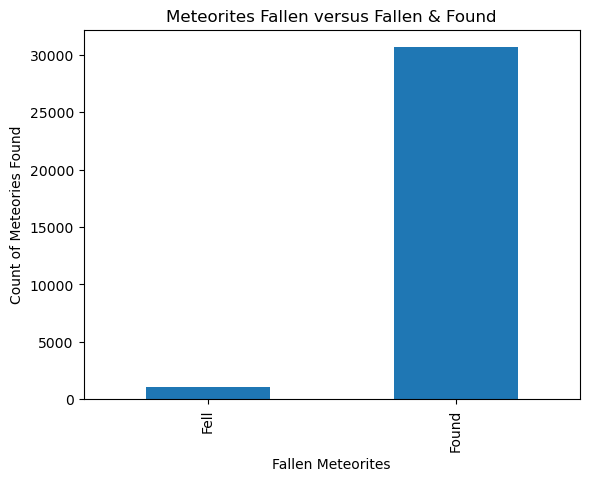

In [55]:
#Using Barchart to compare the number of fall and found versus fallen meteorites.
found_meteor_df = df.groupby(["fall"])
df.groupby("fall").count()["GeoLocation"].plot(kind='bar')
plt.title('Meteorites Fallen versus Fallen & Found')
plt.xlabel('Fallen Meteorites')
plt.ylabel("Count of Meteories Found")
plt.savefig("Images/Barchart-FallvsFallandFound.png")
plt.show()


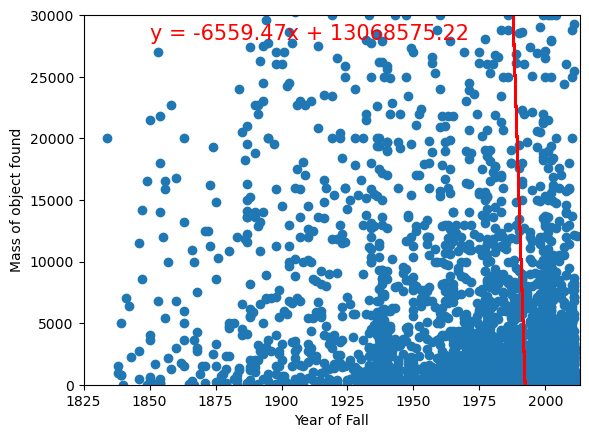

In [56]:
#Fallen and Found related to the Mass of the Object
#How is the year of fallen and found meteorites related to the mass of the object? scatterplots with linear regressions.
found = df.loc[df["fall"] == 'Found',:]
found.head()
plt.scatter(found["year"],found["mass"])
plt.xlim(1825,2013)
plt.ylim(0,30000)
plt.xlabel("Year of Fall")
plt.ylabel("Mass of object found")


#Linear Regression Values
x_values = found["year"]
y_values = found["mass"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1850,28000),fontsize=15,color="red")
plt.savefig("Images/linear-Regression-year-mass.png")
plt.show()


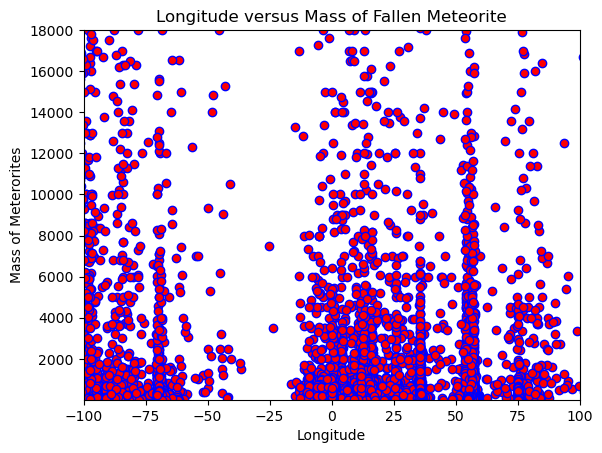

In [57]:
#Corralation between Mass and longitude
plt.scatter(df["reclong"],df["mass"],marker="o",facecolor="red", edgecolors="blue")
plt.title("Longitude versus Mass of Fallen Meteorite")
plt.xlabel("Longitude")
plt.ylabel("Mass of Meterorites")
plt.xlim(-100,100)
plt.ylim(10,18000)
plt.savefig("Images/scatter-mass-longitude.png")
plt.show()

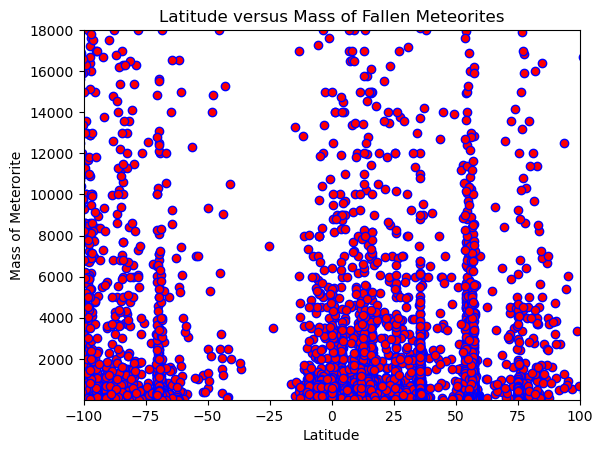

In [58]:
#Correllation of mass and latitude
plt.scatter(df["reclong"],df["mass"],marker="o",facecolor="red", edgecolors="blue")
plt.title("Latitude versus Mass of Fallen Meteorites")
plt.xlabel("Latitude")
plt.ylabel("Mass of Meterorite")
plt.xlim(-100,100)
plt.ylim(10,18000)
plt.savefig("Images/scatter-mass-latitude.png")
plt.show()


In [59]:
#Used the GeoLocation to determine the average of the lat and lon.
df_geo = df['GeoLocation'].str.replace('(','').str.replace(')','').str.split(',',expand=True).astype('float64')
#df_geo.mean()
mean_impact = pd.DataFrame({"Lat":df_geo[0].mean(),"Long":df_geo[1].mean()},index=[1])
mean_impact.head()


/var/folders/y5/1j7tkx0d3ps47_05_gxzvm780000gn/T/ipykernel_81269/1869967983.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_geo = df['GeoLocation'].str.replace('(','').str.replace(')','').str.split(',',expand=True).astype('float64')


,Lat,Long
1,-47.602009,73.452607


In [60]:
#Plotting the Average impact site.
map_plot_impact_mean = mean_impact.hvplot.points(
    'Long',
    'Lat',
    geo = True,
    tiles = "OSM",
    frame_width= 1000,
    frame_height = 600,
    color = "red",
    size = 10,
    scale= 20,
    hover_cols ="all",
    ylim = (-80,50),
    xlim = (50,85),
    title = "Average Impact Location",
    xlabel = "Latitude",
    ylabel = "Longitude"
    
    )

map_plot_impact_mean

# Save the figure
hvplot.save(map_plot_impact_mean, 'Images/Averageimpactsites.png')

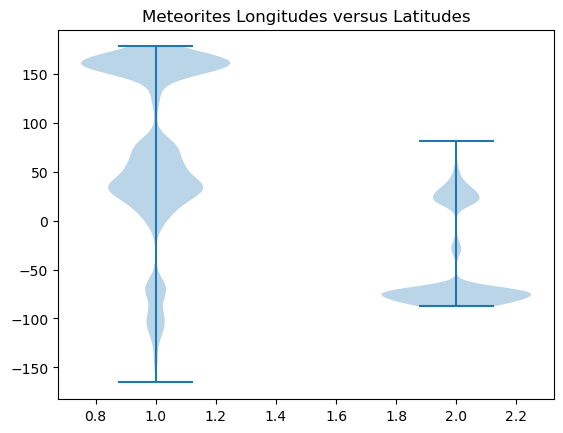

In [61]:
#Using a violine plot to get a isolated visuals on where most of the lat or long of meteorites were found. Lat and Lon are independently displayed in the graph.
bins = [x for x in range(-200, 200, 25)]
df_cut = pd.cut(df['reclong'], bins, labels=bins[:-1])
plt.violinplot(df[['reclong','reclat']])
plt.title("Meteorites Longitudes versus Latitudes")
plt.savefig("Images/violin-Lat-Lon.png")
plt.show()

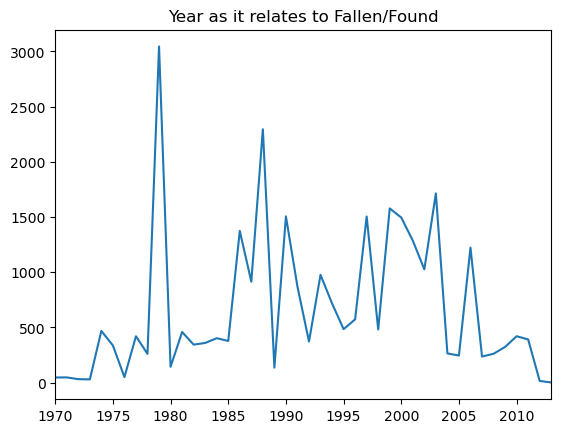

In [62]:
#how are fallen/found related to the year?
year_fall_count = df.groupby(["year"])["fall"].count()
year = df.groupby(["year"])["year"].unique()
plt.plot(year,year_fall_count)
plt.title("Year as it relates to Fallen/Found")
plt.xlim(1970,df["year"].max())
plt.savefig("Images/boxplot-hemisphere.png")
plt.show()



In [63]:
#Most frequently hit impact sites we've got the top 6 impact sites. We just need to plot these using the lat and long.
lat_long = df.groupby(["reclat", "reclong"],as_index = False)
lat_long_count = lat_long.count()

#Creating a dataframe with lat, long, and name to merge back to original data frame creating a Max Impact column
lat_long_count_three = pd.DataFrame(lat_long_count, columns=["reclat","reclong","name"])

#Merge the lat long back to the original df to set max impact
merge_meteor = pd.merge(df,lat_long_count_three, on=["reclat","reclong"])
merge_meteor = merge_meteor.rename(columns={"name_y": "Max Impact","name_x":"name"})

#Find sites with a max impact of 500 or more.
top_meteor = merge_meteor.loc[merge_meteor["Max Impact"] >= 500]
max_impact = top_meteor.groupby(["reclat","reclong"], as_index=False)["Max Impact"].max()
max_impact.head()
geo_list = pd.DataFrame(max_impact)
geo_list.columns


Index(['reclat', 'reclong', 'Max Impact'], dtype='object')

In [65]:

map_plot_impact = geo_list.hvplot.points(
    'reclong',
    'reclat',
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600,
    color = "Max Impact",
    size = "Max Impact",
    hover_cols ="all",
    title="Frequenty Fallen Meteorite Locations"
    )

map_plot_impact
# Save the figure
hvplot.save(map_plot_impact, 'Images/Top-6frequentlyImpactedsites.png')

In [ ]:
#Create Norhthern Hemisphere for all Latitudes above or equal to 0
northern_hemi_df = merge_meteor.loc[merge_meteor["reclat"] >= 0]
northern_mass = northern_hemi_df["mass"].sort_values(ascending=True)

#Create Southern Hemisphere less than 0
southern_hemi_df = merge_meteor.loc[merge_meteor["reclat"] < 0]
southern_mass = southern_hemi_df["mass"].sort_values(ascending=True)


In [ ]:
#Northern Hemisphere Quartiles
quartiles_north = northern_mass.quantile([.25,.5,.75])
low_q_north = quartiles_north[0.25]
upp_q_north = quartiles_north[0.75]
#Calculate the interqurtile range (IQR)
iqr_north = upp_q_north - low_q_north

#Print IQR and Calculate Upper and lower bounds. 
print(f"IQR for the Northern Hemisphere is {iqr_north}")

#Outliers
lower_bound_north = low_q_north - (1.5*iqr_north)
upper_bound_north = upp_q_north + (1.5*iqr_north)
print(f"The Upper bound is {upper_bound_north}.")
print(f"The Lower bound is {lower_bound_north}.")

#Southern Hemisphere Quartiles
quartiles_south = southern_mass.quantile([.25,.5,.75])
low_q_south = quartiles_south[0.25]
upp_q_south = quartiles_south[0.75]

#Calculate the interqurtile range (IQR)
iqr_south = upp_q_south - low_q_south

#Print IQR and Calculate Upper and lower bounds. 
print(f"IQR for the Southern Hemisphere is {iqr_south}")

#Outliers
lower_bound_south = low_q_south - (1.5*iqr_south)
upper_bound_south = upp_q_south + (1.5*iqr_south)
print(f"The Upper bound is {upper_bound_south}.")
print(f"The Lower bound is {lower_bound_south}.")


IQR for the Northern Hemisphere is 1897.0
The Upper bound is 4845.5.
The Lower bound is -2742.5.
IQR for the Southern Hemisphere is 54.540000000000006
The Upper bound is 140.4925.
The Lower bound is -77.6675.


In [ ]:
#Moving to a list and removing duplicates from list
mass_list_north = northern_mass.tolist()
mass_list_north = list(dict.fromkeys(mass_list_north))

#Moving to a list and removing duplicates from list
mass_list_south = southern_mass.tolist()
mass_list_south = list(dict.fromkeys(mass_list_south))


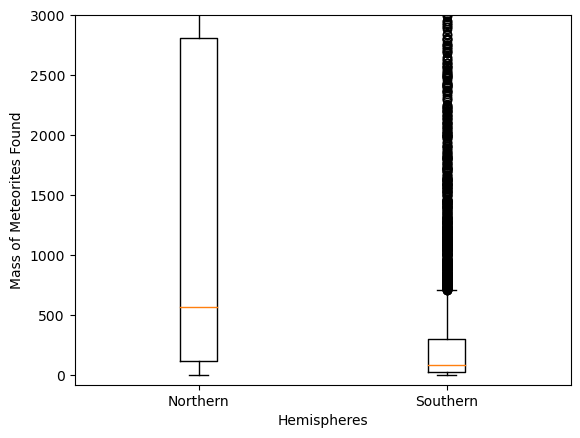

In [ ]:
#Using boxplot to compare northern hemisphere to southern hemisphere as it relates to mass of meterorites found.
hemi_plot = [mass_list_north,mass_list_south]
fig1,ax1 = plt.subplots()
ax1.set_ylabel("Mass of Meteorites Found")
ax1.set_xlabel("Hemispheres")
ax1.boxplot(hemi_plot)
plt.xticks([1,2],["Northern","Southern"])
ax1.set_ylim(-80,3000)
plt.savefig("Images/boxplot-hemisphere.png")
plt.show()